# Function Generation for the Training of λ-Nets

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes


config = {
    'function_family': {
        'maximum_depth': 4,
        'beta': 1,
        'decision_sparsity': 1,
        'fully_grown': True,
        'dt_type': 'vanilla', #'vanilla', 'SDT'
    },
    'data': {
        'number_of_variables': 10, 
        'num_classes': 2,
        'categorical_indices': [],
        
        'function_generation_type': 'distribtion_trained', # 'make_classification_distribution', 'make_classification_distribution_trained', 'distribtion', 'distribtion_trained', 'make_classification', 'make_classification_trained', 'random_decision_tree', 'random_decision_tree_trained'
        'objective': 'classification', # 'regression'
        
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform',       
                
        'lambda_dataset_size': 5000, #number of samples per function
        'number_of_generated_datasets': 10001,
    }, 
    'computation':{
        'n_jobs': 20,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}


In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['computation'])

## Imports

In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from itertools import product       # forms cartesian products
from more_itertools import random_product 
from tqdm import tqdm_notebook as tqdm
import pickle

import numpy as np

import pandas as pd
from joblib import Parallel, delayed

import random 
from random import sample 

import os
import sys

from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler

from sympy import Symbol, sympify

        
import seaborn as sns
        
import random 

import warnings

from time import perf_counter



from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from utilities.DecisionTree_BASIC import SDT
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt
from IPython.display import Image

import numpy as np
import torch
np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)

In [4]:
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################
os.environ['CUDA_VISIBLE_DEVICES'] = ''

sns.set_style("darkgrid")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

In [5]:
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['computation'])

#initialize_utility_functions_config_from_curent_notebook(config)

#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(config, path_type='data_creation'))
generate_directory_structure()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [6]:
print(path_identifier_function_data)

lNetSize5000_numDatasets10001_var10_class2_distribtion_trained_xMax1_xMin0_xDistuniform_depth4_beta1_decisionSpars1_vanilla_fullyGrown


# Function Generation

In [7]:
#if max_distributions_per_class CHANGE NAME

In [8]:
if function_generation_type == 'random_decision_tree':
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    result_list = parallel(delayed(generate_data_random_decision_tree)(config, seed=RANDOM_SEED+i) for i in range(number_of_generated_datasets))
elif function_generation_type == 'random_decision_tree_trained':
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    result_list = parallel(delayed(generate_data_random_decision_tree_trained)(config, seed=RANDOM_SEED+i) for i in range(number_of_generated_datasets))  
elif function_generation_type == 'make_classification':
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    result_list = parallel(delayed(generate_data_make_classification)(config, seed=RANDOM_SEED+i) for i in range(number_of_generated_datasets)) 
elif function_generation_type == 'make_classification_trained':
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    result_list = parallel(delayed(generate_data_make_classification_decision_tree_trained)(config, seed=RANDOM_SEED+i) for i in range(number_of_generated_datasets))    
elif function_generation_type == 'make_classification_distribution':
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    result_list = parallel(delayed(generate_data_make_classification_distribution)(config, seed=RANDOM_SEED+i) for i in range(number_of_generated_datasets)) 
elif function_generation_type == 'make_classification_distribution_trained':
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    result_list = parallel(delayed(generate_data_make_classification_distribution_decision_tree_trained)(config, seed=RANDOM_SEED+i) for i in range(number_of_generated_datasets))    
elif function_generation_type == 'distribtion':
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    result_list = parallel(delayed(generate_data_distribtion)(config, seed=RANDOM_SEED+i, max_distributions_per_class=4, distribution_list = ['uniform']) for i in range(number_of_generated_datasets))    
elif function_generation_type == 'distribtion_trained':
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    result_list = parallel(delayed(generate_data_distribtion_trained)(config, seed=RANDOM_SEED+i, max_distributions_per_class=4, distribution_list = ['uniform']) for i in range(number_of_generated_datasets))    
    
    
function_identifier_list = generate_decision_tree_identifier(config)  
identifier_series_list = [pd.Series(result[0],  index=function_identifier_list) for result in result_list]

function_df = pd.DataFrame(data=np.array([result[0] for result in result_list]), columns=function_identifier_list)

X_data_list = [[identifier_series, pd.DataFrame(result[1], columns=['x' + str(i) for i in range(number_of_variables)])] for identifier_series, result in zip(identifier_series_list, result_list)]
y_data_list = [[identifier_series, pd.DataFrame(result[2], columns=['result'])] for identifier_series, result in zip(identifier_series_list, result_list)]
y_data_raw_list = [[identifier_series, pd.DataFrame(result[3], columns=['result_raw'])] for identifier_series, result in zip(identifier_series_list, result_list)]


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  88 tasks      | elapsed:    7.0s
[Parallel(n_jobs=20)]: Done 744 tasks      | elapsed:    8.1s
[Parallel(n_jobs=20)]: Done 2536 tasks      | elapsed:   10.4s
[Parallel(n_jobs=20)]: Done 4840 tasks      | elapsed:   13.4s
[Parallel(n_jobs=20)]: Done 7656 tasks      | elapsed:   17.0s
[Parallel(n_jobs=20)]: Done 10001 out of 10001 | elapsed:   20.0s finished


In [9]:
function_df.head(20)

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,split0,split1,split2,split3,split4,split5,split6,split7,split8,split9,split10,split11,split12,split13,split14,lp0,lp1,lp2,lp3,lp4,lp5,lp6,lp7,lp8,lp9,lp10,lp11,lp12,lp13,lp14,lp15
0,0.404,0.341,-1.000,-1.000,0.537,-1.000,-1.000,-1.000,-1.000,0.297,-1.000,-1.000,-1.000,-1.000,-1.000,1.000,1.000,-1.000,-1.000,3.000,-1.000,-1.000,-1.000,-1.000,3.000,-1.000,-1.000,-1.000,-1.000,-1.000,0.000,0.000,0.000,0.000,0.000,0.989,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.415,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,6.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.072,0.800,0.070,0.302,-1.000,0.374,0.466,0.531,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,0.421,1.000,2.000,0.000,9.000,-1.000,5.000,1.000,4.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,7.000,0.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.216,0.745
3,0.559,0.823,0.110,-1.000,0.835,-1.000,-1.000,-1.000,-1.000,0.411,-1.000,-1.000,-1.000,-1.000,-1.000,9.000,1.000,4.000,-1.000,1.000,-1.000,-1.000,-1.000,-1.000,0.000,-1.000,-1.000,-1.000,-1.000,-1.000,0.000,0.000,0.000,0.000,0.977,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000
4,0.252,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,8.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
5,0.672,0.765,-1.000,0.643,-1.000,-1.000,-1.000,0.766,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,2.000,8.000,-1.000,4.000,-1.000,-1.000,-1.000,1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,0.921,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6,0.680,0.388,-1.000,0.857,0.143,-1.000,-1.000,0.060,0.308,0.413,-1.000,-1.000,-1.000,-1.000,-1.000,4.000,8.000,-1.000,1.000,0.000,-1.000,-1.000,0.000,2.000,2.000,-1.000,-1.000,-1.000,-1.000,-1.000,0.000,0.975,1.000,0.136,0.843,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
7,0.588,-1.000,0.584,-1.000,-1.000,0.580,-1.000,-1.000,-1.000,-1.000,-1.000,0.350,-1.000,-1.000,-1.000,8.000,-1.000,6.000,-1.000,-1.000,4.000,-1.000,-1.000,-1.000,-1.000,-1.000,4.000,-1.000,-1.000,-1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.944,0.000,0.000,0.000,0.000,0.000,0.000
8,0.688,0.737,-1.000,0.755,0.529,-1.000,-1.000,0.635,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,7.000,1.000,-1.000,3.000,7.000,-1.000,-1.000,5.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,0.786,0.131,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
9,0.820,0.264,-1.000,0.159,-1.000,-1.000,-1.000,0.162,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,7.000,8.000,-1.000,9.000,-1.000,-1.000,-1.000,7.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,0.088,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [10]:
X_data_list[0][0].head(10)

feat0    0.404
feat1    0.341
feat2   -1.000
feat3   -1.000
feat4    0.537
feat5   -1.000
feat6   -1.000
feat7   -1.000
feat8   -1.000
feat9    0.297
dtype: float64

In [11]:
X_data_list[0][1].head(10)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,0.285,0.391,0.162,0.334,0.449,0.298,0.126,0.092,0.438,0.863
1,0.096,0.390,0.424,0.456,0.219,0.553,0.006,0.267,0.661,0.571
2,0.872,0.393,0.228,0.335,0.782,0.197,0.436,0.793,0.075,0.123
3,0.253,0.344,0.178,0.480,0.436,0.254,0.143,0.294,0.020,0.965
4,0.430,0.360,0.869,0.317,0.400,0.557,0.515,0.832,0.452,0.669
5,0.345,0.352,0.334,0.321,0.435,0.715,0.000,0.705,0.856,0.725
6,0.115,0.366,0.805,0.336,0.329,0.160,0.507,0.433,0.509,0.852
7,0.850,0.397,0.462,0.315,0.068,0.339,0.636,0.696,0.338,0.271
8,0.855,0.359,0.375,0.420,0.371,0.043,0.594,0.044,0.211,0.778
9,0.973,0.384,0.650,0.513,0.270,0.075,0.652,0.320,0.816,0.113


In [12]:
y_data_list[0][0].head(10)

feat0    0.404
feat1    0.341
feat2   -1.000
feat3   -1.000
feat4    0.537
feat5   -1.000
feat6   -1.000
feat7   -1.000
feat8   -1.000
feat9    0.297
dtype: float64

In [13]:
y_data_list[1][1].head(10)

,result
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [14]:
y_data_list[2][1].head(10)

,result
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [15]:
y_data_raw_list[2][1].head(10)

,result_raw
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


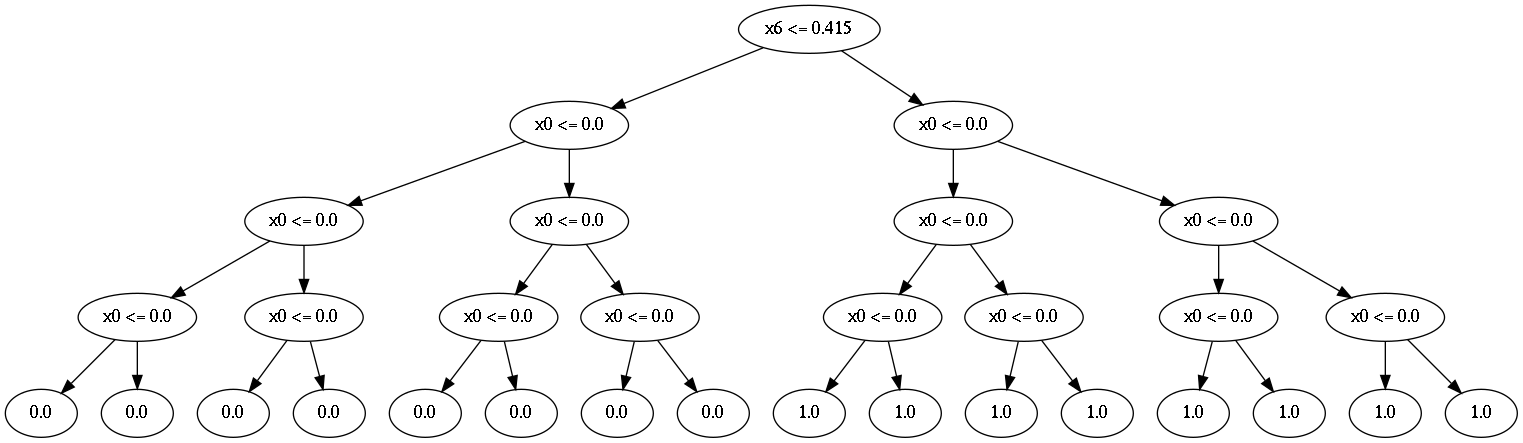

In [16]:
plot_tree_from_parameters(y_data_list[1][0].values, config)

In [17]:
path_functions = './data/saved_function_lists/functions_' + path_identifier_function_data + '.csv'
function_df.to_csv(path_functions, index=False)

path_X_data = './data/saved_function_lists/X_data_' + path_identifier_function_data + '.pkl'
with open(path_X_data, 'wb') as f:
    pickle.dump(X_data_list, f)
    
path_y_data = './data/saved_function_lists/y_data_' + path_identifier_function_data + '.pkl'
with open(path_y_data, 'wb') as f:
    pickle.dump(y_data_list, f)
